In [40]:
import os
import importlib as il

import pandas as pd
import numpy as np
import importlib as il
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch.utils.data.sampler import Sampler
import torch.optim as optim
from torchvision import transforms, models

import classification_methods as clm
from mlcm import mlcm

%matplotlib inline

%load_ext ipydex.displaytools

In [2]:
from approach2 import model_evaluation as me

Total groups read: 15


In [3]:
il.reload(clm)
il.reload(me)

m = me.Manager()

m.load_model(f"{me.PARENT_DIR}/classification_models/CNN_3.pth")
# m.plot_training_curves()

Total groups read: 15
ChocolateCNN
ChocolateCNN
Loaded model type: ChocolateCNN, epoch: 20, validation accuracy: 97.37076648841355%


In [4]:
m.make_predictions(limit=50)

500it [00:01, 382.21it/s]


In [5]:
q = m.predictions[0]
len(m.predictions)

500

In [6]:
q

{'filename': 'b9_s82_2023-06-27_04-18-57_C0_b9.jpg',
 'leichte durchscheinende Füllung': 0,
 'mittlere durchscheinende Füllung': 1,
 'starke durchscheinende Füllung': 0,
 'Bläschen': 0,
 'Füllung über Rand hinaus': 0,
 'Kratzer/Späne auf Deckel': 0,
 'Zelle falsch erkannt': 0,
 'small bright area on upper border': 0,
 'sonstiger Fehler': 0}

In [18]:
tf_100_25 = transforms.Resize((100, 25))



In [7]:
m.model

ChocolateCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9600, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [60]:

# usually the last convolutional layer
cam = GradCAM(model=m.model, target_layers=[m.model.conv2])
# Prepare the target
# targets = [ClassifierOutputTarget(class_idx)]


img_fpath = m.img_fpaths_for_prediction[4]

In [61]:
q = m.load_and_preprocess_image(img_fpath)

In [62]:
q.shape

torch.Size([1, 3, 100, 25])

In [63]:
grayscale_cam = cam(input_tensor=m.load_and_preprocess_image(img_fpath), targets=None)

In [64]:
image = np.array(me.Image.open(m.img_fpaths_for_prediction[0])) / 255.0  # Normalize to [0, 1]

# note  cv2.resize takes x dimension (col index) first
image1 = me.cv2.resize(image, (25, 100)) ##:i


info(image1) := "<class 'numpy.ndarray'> with shape: (100, 25, 3)"

---

In [65]:


# Overlay the heatmap on the original image
cam_image = show_cam_on_image(image1, grayscale_cam[0], use_rgb=True)


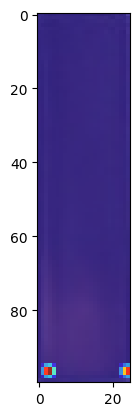

In [66]:
plt.imshow(cam_image)

In [25]:
image.shape

(106, 24, 3)

In [15]:
grayscale_cam[0].shape

(100, 25)

In [16]:
image.shape

(106, 24, 3)

In [61]:
GradCAM??

Init signature: GradCAM(model, target_layers, reshape_transform=None)
Docstring:      <no docstring>
Source:        
class GradCAM(BaseCAM):
    def __init__(self, model, target_layers,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        # 2D image
        if len(grads.shape) == 4:
            return np.mean(grads, axis=(2, 3))
        
        # 3D image
        elif len(grads.shape) == 5:
            return np.mean(grads, axis=(2, 3, 4))
        
        else:
            raise ValueError("Invalid grads shape." 
                             "Shape of grads should be 4 (2D image) or 5 (3D image).")
File:           /media/sd-card-disk/m